In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, label_binarize, OrdinalEncoder
from category_encoders import CatBoostEncoder, MEstimateEncoder

from sklearn.ensemble import RandomForestClassifier, VotingClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.linear_model import RidgeClassifier, LogisticRegression, LinearRegression, Ridge, BayesianRidge

from sklearn import set_config
import os

import optuna
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, mean_squared_error, precision_recall_curve, make_scorer, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, matthews_corrcoef, mean_absolute_percentage_error
from scipy.stats import norm, skew

from colorama import Fore, Style, init
from copy import deepcopy
from sklearn.base import BaseEstimator, TransformerMixin
from pprint import pprint
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold, KFold, RepeatedKFold, cross_val_score, StratifiedGroupKFold, GroupKFold
from xgboost import DMatrix, XGBClassifier, XGBRegressor
from lightgbm import log_evaluation, early_stopping, LGBMClassifier, LGBMRegressor, Dataset
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from tqdm.notebook import tqdm
from optuna.samplers import TPESampler, CmaEsSampler
from optuna.pruners import HyperbandPruner
from functools import partial
from IPython.display import display_html, clear_output
from sklearn.utils.class_weight import compute_class_weight
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
import gc
import re
import holidays
import requests

import warnings
warnings.filterwarnings("ignore")

import keras
from keras.models import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
import warnings
import os
import plotly.graph_objects as go

warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")
# os.listdir()
class Config:
    
    state = 4152
    n_splits = 5
    early_stop = 200
        
    target = 'num_sold'
    train = pd.read_csv('./datadown/train.csv', index_col='id')
    test = pd.read_csv('./datadown/test.csv', index_col='id')
    submission = pd.read_csv('./datadown/sample_submission.csv')

    original_data = 'N'
    outliers = 'N'
    log_trf = 'Y'
    scaler_trf = 'N'
    feature_eng = 'Y'
    missing = 'Y'

In [5]:
try:
    train_df = pd.read_csv("/kaggle/input/playground-series-s5e1/train.csv", parse_dates=["date"])
    test_df = pd.read_csv("/kaggle/input/playground-series-s5e1/test.csv", parse_dates=["date"])
except:
    train_df = pd.read_csv("./datadown/train.csv", parse_dates=["date"])
    test_df = pd.read_csv("./datadown/test.csv", parse_dates=["date"])
gdp_per_capita_df = pd.read_csv("./datadown/gdp_per_capita.csv")
years =  ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]
gdp_per_capita_filtered_df = gdp_per_capita_df.loc[gdp_per_capita_df["Country Name"].isin(train_df["country"].unique()), ["Country Name"] + years].set_index("Country Name")
gdp_per_capita_filtered_df["2010_ratio"] = gdp_per_capita_filtered_df["2010"] / gdp_per_capita_filtered_df.sum()["2010"]
for year in years:
    gdp_per_capita_filtered_df[f"{year}_ratio"] = gdp_per_capita_filtered_df[year] / gdp_per_capita_filtered_df.sum()[year]
gdp_per_capita_filtered_ratios_df = gdp_per_capita_filtered_df[[i+"_ratio" for i in years]]
gdp_per_capita_filtered_ratios_df.columns = [int(i) for i in years]
gdp_per_capita_filtered_ratios_df = gdp_per_capita_filtered_ratios_df.unstack().reset_index().rename(columns = {"level_0": "year", 0: "ratio", "Country Name": "country"})
gdp_per_capita_filtered_ratios_df['year'] = pd.to_datetime(gdp_per_capita_filtered_ratios_df['year'], format='%Y')


In [6]:
class Transform(Config):

    def __init__(self):
        super().__init__()
        if Config.original_data == "Y":
            self.train = pd.concat(
                [self.train, self.train_org], ignore_index=True
            ).drop_duplicates()
            self.train.reset_index(drop=True, inplace=True)

        self.num_features = (
            self.train.drop(self.target, axis=1)
            .select_dtypes(exclude=["object", "bool"])
            .columns.tolist()
        )
        self.cat_features = (
            self.train.drop(self.target, axis=1)
            .select_dtypes(include=["object", "bool"])
            .columns.tolist()
        )

        self.train_raw = self.train.copy()

        if self.feature_eng == "Y":
            self.train = self.new_features(self.train)
            self.test = self.new_features(self.test)
            self.train_raw = self.new_features(self.train_raw)

        if self.missing == "Y":
            self.missing_values()

        self.num_features = (
            self.train.drop(self.target, axis=1)
            .select_dtypes(exclude=["object", "bool"])
            .columns.tolist()
        )
        self.cat_features = (
            self.train.drop(self.target, axis=1)
            .select_dtypes(include=["object", "bool"])
            .columns.tolist()
        )

        if self.outliers == "Y":
            self.remove_outliers()

        if self.log_trf == "Y":
            self.log_transformation()

        if self.scaler_trf == "Y":
            self.scaler()

        self.train_enc = self.train.copy()
        self.test_enc = self.test.copy()
        self.encode()

        if self.outliers == "Y" or self.log_trf == "Y" or self.scaler_trf == "Y":
            self.distribution()

    def __call__(self):

        self.train[self.cat_features] = self.train[self.cat_features].astype("category")
        self.test[self.cat_features] = self.test[self.cat_features].astype("category")

        self.cat_features_card = []
        for f in self.cat_features:
            self.cat_features_card.append(self.train[f].nunique())

        self.train = self.reduce_mem(self.train)
        self.test = self.reduce_mem(self.test)

        self.y = self.train[self.target]
        self.train = self.train.drop(self.target, axis=1)
        self.train_enc = self.train_enc.drop(self.target, axis=1)

        return (
            self.train,
            self.train_enc,
            self.y,
            self.test,
            self.test_enc,
            self.cat_features,
        )

    def encode(self):
        data = pd.concat([self.test, self.train])
        oe = OrdinalEncoder()
        data[self.cat_features] = oe.fit_transform(data[self.cat_features]).astype(
            "int"
        )

        scaler = StandardScaler()
        data[self.num_features + [self.target]] = scaler.fit_transform(
            data[self.num_features + [self.target]]
        )

        self.train_enc = data[~data[self.target].isna()]
        self.test_enc = data[data[self.target].isna()].drop(self.target, axis=1)

    def new_features(self, data):
        data["date"] = pd.to_datetime(data["date"])
        data["quarter"] = data["date"].dt.quarter.astype("object")
        data["month"] = data["date"].dt.month
        data["month_sin"] = np.sin(data["month"] * (2 * np.pi / 12))
        data["month_cos"] = np.cos(data["month"] * (2 * np.pi / 12))
        data["day"] = data["date"].dt.day
        data["day_sin"] = np.sin(data["day"] * (2 * np.pi / 31))
        data["day_cos"] = np.cos(data["day"] * (2 * np.pi / 31))
        data["day_of_week"] = data["date"].dt.dayofweek.astype("object")
        data["day_of_year"] = data["date"].dt.dayofyear.astype("object")
        # data["day_of_week"] = data["day_of_week"].apply(
        #     lambda x: 0 if x <= 3 else (1 if x == 4 else (2 if x == 5 else (3)))
        # )
        data["week"] = data["date"].dt.isocalendar().week
        data["week_sin"] = np.sin(data["week"] * (2 * np.pi / 53))
        data["week_cos"] = np.cos(data["week"] * (2 * np.pi / 53))
        data["year"] = data["date"].dt.year
        data["cos_year"] = np.cos(data["year"] * (2 * np.pi) / 100)
        data["sin_year"] = np.sin(data["year"] * (2 * np.pi) / 100)
        data[["month", "day", "week", "year"]] = data[
            ["month", "day", "week", "year"]
        ].astype("object")
        data["group"] = (
            (data["year"] - 2020) * 48 + data["month"] * 4 + data["day"] // 7
        )
        data = pd.get_dummies(data, columns=["day_of_week"], drop_first=True)
        data["important_dates"] = data["day_of_year"].apply(
            lambda x: (
                x
                if x
                in [
                    1,
                    2,
                    3,
                    4,
                    5,
                    6,
                    7,
                    8,
                    9,
                    10,
                    99,
                    100,
                    101,
                    125,
                    126,
                    355,
                    256,
                    357,
                    358,
                    359,
                    360,
                    361,
                    362,
                    363,
                    364,
                    365,
                ]
                else 0
            )
        )
        data.drop(columns=["day_of_year"], inplace=True)

        for day in range(24, 32):
            data[f"dec{day}"] = (
                (data.date.dt.day.eq(day) & data.date.dt.month.eq(12))
                .astype(np.uint8)
                .astype("object")
            )

        alpha2 = dict(
            zip(np.sort(data.country.unique()), ["CA", "FI", "IT", "KE", "NO", "SG"])
        )
        h = {
            c: holidays.country_holidays(a, years=range(2010, 2020))
            for c, a in alpha2.items()
        }
        data["is_holiday"] = 0
        for c in alpha2:
            data.loc[data.country == c, "is_holiday"] = (
                data.date.isin(h[c]).astype(int).astype("object")
            )

        try:
            gdp_df = pd.read_csv("./datadown/gdp_df.csv")#.drop('Unnamed: 0', axis = 1)
        except:
            print("no gdp data")
            gdp = []
            for country in data.country.unique():
                row = []
                for year in range(2010,2020):
                    row.append(self.get_gdp(country,year))
                gdp.append(row)

            gdp = np.array(gdp)
            gdp /= np.sum(gdp,axis=0)

            gdp_df = pd.DataFrame(gdp, index=data.country.unique(), columns=range(2010,2020))
            gdp_df = gdp_df.reset_index().melt(id_vars = ['index']).rename({'index': 'country', 'variable': 'year', 'value': 'GDP'}, axis=1)
        data = data.merge(gdp_df, how="left", on=["year", "country"])

        return data

    def product_weights(self, train_df_imputed):
        """
        previous baseline no model. kaggle/s5e1-previous-years-baseline-no-model.ipynb
        """
        store_weights = train_df_imputed.groupby("store")["num_sold"].sum()/train_df_imputed["num_sold"].sum()
        product_df = train_df_imputed.groupby(["date","product"])["num_sold"].sum().reset_index()
        product_ratio_df = product_df.pivot(index="date", columns="product", values="num_sold")
        product_ratio_df = product_ratio_df.apply(lambda x: x/x.sum(),axis=1)
        product_ratio_df = product_ratio_df.stack().rename("ratios").reset_index()
        product_ratio_2017_df = product_ratio_df.loc[product_ratio_df["date"].dt.year == 2015].copy()
        product_ratio_2018_df = product_ratio_df.loc[product_ratio_df["date"].dt.year == 2016].copy()
        product_ratio_2019_df = product_ratio_df.loc[product_ratio_df["date"].dt.year == 2015].copy()

        product_ratio_2017_df["date"] = product_ratio_2017_df["date"] + pd.DateOffset(years=2)
        product_ratio_2018_df["date"] = product_ratio_2018_df["date"] + pd.DateOffset(years=2)
        product_ratio_2019_df["date"] =  product_ratio_2019_df["date"] + pd.DateOffset(years=4)

        forecasted_ratios_df = pd.concat([product_ratio_2017_df, product_ratio_2018_df, product_ratio_2019_df])


    def log_transformation(self):
        self.train[self.target] = np.log1p(self.train[self.target])
        return self

    def distribution(self):
        print(Style.BRIGHT + Fore.GREEN + f"\nHistograms of distribution\n")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

        ax_r, ax_n = axes

        ax_r.set_title(
            f"{self.target} ($\mu=$ {self.train_raw[self.target].mean():.2f} and $\sigma=$ {self.train_raw[self.target].std():.2f} )"
        )
        ax_r.hist(self.train_raw[self.target], bins=30, color="#3cb371")
        ax_r.axvline(self.train_raw[self.target].mean(), color="r", label="Mean")
        ax_r.axvline(
            self.train_raw[self.target].median(),
            color="y",
            linestyle="--",
            label="Median",
        )
        ax_r.legend()

        ax_n.set_title(
            f"{self.target} Normalized ($\mu=$ {self.train_enc[self.target].mean():.2f} and $\sigma=$ {self.train_enc[self.target].std():.2f} )"
        )
        ax_n.hist(self.train_enc[self.target], bins=30, color="#3cb371")
        ax_n.axvline(self.train_enc[self.target].mean(), color="r", label="Mean")
        ax_n.axvline(
            self.train_enc[self.target].median(),
            color="y",
            linestyle="--",
            label="Median",
        )
        ax_n.legend()

    def remove_outliers(self):
        Q1 = self.train[self.targets].quantile(0.25)
        Q3 = self.train[self.targets].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        self.train = self.train[
            (self.train[self.targets] >= lower_limit)
            & (self.train[self.targets] <= upper_limit)
        ]
        self.train.reset_index(drop=True, inplace=True)

    def scaler(self):
        scaler = StandardScaler()
        self.train[self.num_features] = scaler.fit_transform(
            self.train[self.num_features]
        )
        self.test[self.num_features] = scaler.transform(self.test[self.num_features])
        return self

    def missing_values(self):
        train_df_imputed = self.train.copy()
        for year in train_df_imputed["year"].unique():
            target_ratio = train_df_imputed.loc[
                (train_df_imputed["year"] == year)
                & (train_df_imputed["country"] == "Norway"),
                "GDP",
            ].values[0]
            current_raito = train_df_imputed.loc[
                (train_df_imputed["year"] == year)
                & (train_df_imputed["country"] == "Canada"),
                "GDP",
            ].values[0]
            ratio_can = current_raito / target_ratio
            train_df_imputed.loc[
                (train_df_imputed["country"] == "Canada")
                & (train_df_imputed["store"] == "Discount Stickers")
                & (train_df_imputed["product"] == "Holographic Goose")
                & (train_df_imputed["year"] == year),
                "num_sold",
            ] = (
                train_df_imputed.loc[
                    (train_df_imputed["country"] == "Norway")
                    & (train_df_imputed["store"] == "Discount Stickers")
                    & (train_df_imputed["product"] == "Holographic Goose")
                    & (train_df_imputed["year"] == year),
                    "num_sold",
                ]
                * ratio_can
            ).values

            current_ts = train_df_imputed.loc[
                (train_df_imputed["country"] == "Canada")
                & (train_df_imputed["store"] == "Premium Sticker Mart")
                & (train_df_imputed["product"] == "Holographic Goose")
                & (train_df_imputed["year"] == year)
            ]
            missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
            train_df_imputed.loc[
                (train_df_imputed["country"] == "Canada")
                & (train_df_imputed["store"] == "Premium Sticker Mart")
                & (train_df_imputed["product"] == "Holographic Goose")
                & (train_df_imputed["year"] == year)
                & (train_df_imputed["date"].isin(missing_ts_dates)),
                "num_sold",
            ] = (
                train_df_imputed.loc[
                    (train_df_imputed["country"] == "Norway")
                    & (train_df_imputed["store"] == "Premium Sticker Mart")
                    & (train_df_imputed["product"] == "Holographic Goose")
                    & (train_df_imputed["year"] == year)
                    & (train_df_imputed["date"].isin(missing_ts_dates)),
                    "num_sold",
                ]
                * ratio_can
            ).values

            current_ts = train_df_imputed.loc[
                (train_df_imputed["country"] == "Canada")
                & (train_df_imputed["store"] == "Stickers for Less")
                & (train_df_imputed["product"] == "Holographic Goose")
                & (train_df_imputed["year"] == year)
            ]
            missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
            train_df_imputed.loc[
                (train_df_imputed["country"] == "Canada")
                & (train_df_imputed["store"] == "Stickers for Less")
                & (train_df_imputed["product"] == "Holographic Goose")
                & (train_df_imputed["year"] == year)
                & (train_df_imputed["date"].isin(missing_ts_dates)),
                "num_sold",
            ] = (
                train_df_imputed.loc[
                    (train_df_imputed["country"] == "Norway")
                    & (train_df_imputed["store"] == "Stickers for Less")
                    & (train_df_imputed["product"] == "Holographic Goose")
                    & (train_df_imputed["year"] == year)
                    & (train_df_imputed["date"].isin(missing_ts_dates)),
                    "num_sold",
                ]
                * ratio_can
            ).values

            current_raito = train_df_imputed.loc[
                (train_df_imputed["year"] == year)
                & (train_df_imputed["country"] == "Kenya"),
                "GDP",
            ].values[0]
            ratio_ken = current_raito / target_ratio
            train_df_imputed.loc[
                (train_df_imputed["country"] == "Kenya")
                & (train_df_imputed["store"] == "Discount Stickers")
                & (train_df_imputed["product"] == "Holographic Goose")
                & (train_df_imputed["year"] == year),
                "num_sold",
            ] = (
                train_df_imputed.loc[
                    (train_df_imputed["country"] == "Norway")
                    & (train_df_imputed["store"] == "Discount Stickers")
                    & (train_df_imputed["product"] == "Holographic Goose")
                    & (train_df_imputed["year"] == year),
                    "num_sold",
                ]
                * ratio_ken
            ).values

            current_ts = train_df_imputed.loc[
                (train_df_imputed["country"] == "Kenya")
                & (train_df_imputed["store"] == "Premium Sticker Mart")
                & (train_df_imputed["product"] == "Holographic Goose")
                & (train_df_imputed["year"] == year)
            ]
            missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
            train_df_imputed.loc[
                (train_df_imputed["country"] == "Kenya")
                & (train_df_imputed["store"] == "Premium Sticker Mart")
                & (train_df_imputed["product"] == "Holographic Goose")
                & (train_df_imputed["year"] == year)
                & (train_df_imputed["date"].isin(missing_ts_dates)),
                "num_sold",
            ] = (
                train_df_imputed.loc[
                    (train_df_imputed["country"] == "Norway")
                    & (train_df_imputed["store"] == "Premium Sticker Mart")
                    & (train_df_imputed["product"] == "Holographic Goose")
                    & (train_df_imputed["year"] == year)
                    & (train_df_imputed["date"].isin(missing_ts_dates)),
                    "num_sold",
                ]
                * ratio_ken
            ).values

            current_ts = train_df_imputed.loc[
                (train_df_imputed["country"] == "Kenya")
                & (train_df_imputed["store"] == "Stickers for Less")
                & (train_df_imputed["product"] == "Holographic Goose")
                & (train_df_imputed["year"] == year)
            ]
            missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
            train_df_imputed.loc[
                (train_df_imputed["country"] == "Kenya")
                & (train_df_imputed["store"] == "Stickers for Less")
                & (train_df_imputed["product"] == "Holographic Goose")
                & (train_df_imputed["year"] == year)
                & (train_df_imputed["date"].isin(missing_ts_dates)),
                "num_sold",
            ] = (
                train_df_imputed.loc[
                    (train_df_imputed["country"] == "Norway")
                    & (train_df_imputed["store"] == "Stickers for Less")
                    & (train_df_imputed["product"] == "Holographic Goose")
                    & (train_df_imputed["year"] == year)
                    & (train_df_imputed["date"].isin(missing_ts_dates)),
                    "num_sold",
                ]
                * ratio_ken
            ).values

            current_ts = train_df_imputed.loc[
                (train_df_imputed["country"] == "Kenya")
                & (train_df_imputed["store"] == "Discount Stickers")
                & (train_df_imputed["product"] == "Kerneler")
                & (train_df_imputed["year"] == year)
            ]
            missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
            train_df_imputed.loc[
                (train_df_imputed["country"] == "Kenya")
                & (train_df_imputed["store"] == "Discount Stickers")
                & (train_df_imputed["product"] == "Kerneler")
                & (train_df_imputed["year"] == year)
                & (train_df_imputed["date"].isin(missing_ts_dates)),
                "num_sold",
            ] = (
                train_df_imputed.loc[
                    (train_df_imputed["country"] == "Norway")
                    & (train_df_imputed["store"] == "Discount Stickers")
                    & (train_df_imputed["product"] == "Kerneler")
                    & (train_df_imputed["year"] == year)
                    & (train_df_imputed["date"].isin(missing_ts_dates)),
                    "num_sold",
                ]
                * ratio_ken
            ).values

        train_df_imputed.loc[train_df_imputed.index == 23719, "num_sold"] = 4
        train_df_imputed.loc[train_df_imputed.index == 207003, "num_sold"] = 195
        self.train = train_df_imputed.drop("date", axis=1)
        self.test.drop("date", axis=1, inplace=True)
        return self

    def reduce_mem(self, df):

        numerics = [
            "int16",
            "int32",
            "int64",
            "float16",
            "float32",
            "float64",
            "uint16",
            "uint32",
            "uint64",
        ]

        for col in df.columns:
            col_type = df[col].dtypes

            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if "int" in str(col_type):
                    if c_min >= np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif (
                        c_min >= np.iinfo(np.int16).min
                        and c_max < np.iinfo(np.int16).max
                    ):
                        df[col] = df[col].astype(np.int16)
                    elif (
                        c_min >= np.iinfo(np.int32).min
                        and c_max < np.iinfo(np.int32).max
                    ):
                        df[col] = df[col].astype(np.int32)
                    elif (
                        c_min >= np.iinfo(np.int64).min
                        and c_max < np.iinfo(np.int64).max
                    ):
                        df[col] = df[col].astype(np.int64)
                else:
                    if (
                        c_min >= np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                    ):
                        df[col] = df[col].astype(np.float16)
                    if (
                        c_min >= np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                    ):
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)

        return df

    def get_gdp(self, country, year):
        alpha3 = {
            "Canada": "CAN",
            "Finland": "FIN",
            "Italy": "ITA",
            "Kenya": "KEN",
            "Norway": "NOR",
            "Singapore": "SGP",
        }

        url = "https://api.worldbank.org/v2/country/{0}/indicator/NY.GDP.PCAP.CD?date={1}&format=json".format(
            alpha3[country], year
        )
        response = requests.get(url).json()
        return response[1][0]["value"]


Histograms of distribution



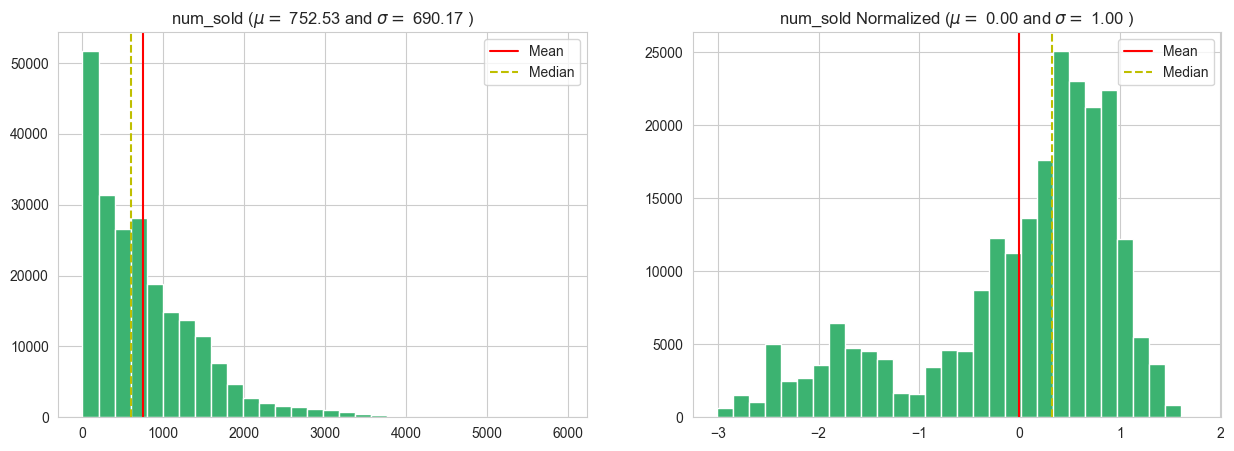

In [7]:
# 15 sec
t = Transform()
X, X_enc, y, test, test_enc, cat_features = t()

In [21]:
nomodel_sub = pd.read_csv('./dataup/nomodel_sub.csv')

In [102]:
pd.read_csv("./dataup/f_product_ration.csv")

,date,product,ratios
0,2010-01-01,Holographic Goose,0.052441
1,2010-01-01,Kaggle,0.329305
2,2010-01-01,Kaggle Tiers,0.291165
3,2010-01-01,Kerneler,0.152373
4,2010-01-01,Kerneler Dark Mode,0.174715
...,...,...,...
12780,2016-12-31,Holographic Goose,0.053591
12781,2016-12-31,Kaggle,0.339649
12782,2016-12-31,Kaggle Tiers,0.270557
12783,2016-12-31,Kerneler,0.152138


In [103]:

def get_X_new(X, X_enc):
    X['date'] = pd.to_datetime(X['year'].astype(str) + X['month'].astype(str).str.zfill(2) +  X['day'].astype(str).str.zfill(2)).astype(str)
    X_new = X.merge(
        pd.read_csv("./dataup/f_cals.csv")[
            ["date", "day_of_week_ratios", "adjusted_num_sold"]
        ],
        on=["date"],
        how="left",
    )
    X_new = X_new.merge(
        pd.read_csv("./dataup/f_gdp_per_capita.csv")[["year", "country", "ratio"]],
        on=["year", "country"],
        how="left",
    ).rename(columns={"ratio": "country_ratio"})
    X_new = X_new.merge(
        pd.read_csv("./dataup/f_product_ration.csv"), on=["date", "product"], how="left"
    ).rename(columns={"ratios": "product_ratio"})
    X_new = X_new.merge(
        pd.read_csv("./dataup/f_store_ration.csv").rename(
            columns={"num_sold": "store_ratio"}
        ),
        on=["store"],
        how="left",
    )

    X_new["num_sold_pseudo_label"] = (
        X_new["adjusted_num_sold"]
        * X_new["day_of_week_ratios"]
        * X_new["store_ratio"]
        * X_new["country_ratio"]
        * X_new["product_ratio"]
    )

    X_new.drop(columns = ['date','GDP'], inplace = True)
    # X_new.head(2)
    X_enc = pd.concat([X_enc, X_new[['day_of_week_ratios','adjusted_num_sold','country_ratio','product_ratio','store_ratio','num_sold_pseudo_label']]], axis=1)

    return X_new

In [85]:
def sc_(df, dftest, col):
    s = StandardScaler()
    df[col] = s.fit_transform(df[col].values.reshape(-1, 1))
    dftest[col] = s.transform(dftest[col].values.reshape(-1, 1))
    return df, dftest

In [106]:
X = get_X_new(X)

In [111]:
X

,country,store,product,quarter,month,month_sin,month_cos,day,day_sin,day_cos,week,week_sin,week_cos,year,cos_year,sin_year,group,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,important_dates,dec24,dec25,dec26,dec27,dec28,dec29,dec30,dec31,is_holiday,GDP,day_of_week_ratios,adjusted_num_sold,country_ratio,product_ratio,store_ratio,num_sold_pseudo_label
0,Canada,Discount Stickers,Holographic Goose,1,1,0.5,0.866211,1,0.201294,0.979492,53,-0.0,1.0,2010,0.809082,0.587891,-476,False,False,False,True,False,False,1,0,0,0,0,0,0,0,0,1,0.178345,1.000503,79191.937980,0.178782,0.052441,0.184716,137.214251
1,Canada,Discount Stickers,Kaggle,1,1,0.5,0.866211,1,0.201294,0.979492,53,-0.0,1.0,2010,0.809082,0.587891,-476,False,False,False,True,False,False,1,0,0,0,0,0,0,0,0,1,0.178345,1.000503,79191.937980,0.178782,0.329305,0.184716,861.639185
2,Canada,Discount Stickers,Kaggle Tiers,1,1,0.5,0.866211,1,0.201294,0.979492,53,-0.0,1.0,2010,0.809082,0.587891,-476,False,False,False,True,False,False,1,0,0,0,0,0,0,0,0,1,0.178345,1.000503,79191.937980,0.178782,0.291165,0.184716,761.844730
3,Canada,Discount Stickers,Kerneler,1,1,0.5,0.866211,1,0.201294,0.979492,53,-0.0,1.0,2010,0.809082,0.587891,-476,False,False,False,True,False,False,1,0,0,0,0,0,0,0,0,1,0.178345,1.000503,79191.937980,0.178782,0.152373,0.184716,398.689380
4,Canada,Discount Stickers,Kerneler Dark Mode,1,1,0.5,0.866211,1,0.201294,0.979492,53,-0.0,1.0,2010,0.809082,0.587891,-476,False,False,False,True,False,False,1,0,0,0,0,0,0,0,0,1,0.178345,1.000503,79191.937980,0.178782,0.174715,0.184716,457.149577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,Singapore,Premium Sticker Mart,Holographic Goose,4,12,-0.0,1.000000,31,-0.000000,1.000000,52,-0.118273,0.992981,2016,0.535645,0.844238,-140,False,False,False,False,True,False,0,0,0,0,0,0,0,0,1,0,0.231079,1.056331,84147.671809,0.231209,0.053591,0.441564,486.335447
230126,Singapore,Premium Sticker Mart,Kaggle,4,12,-0.0,1.000000,31,-0.000000,1.000000,52,-0.118273,0.992981,2016,0.535645,0.844238,-140,False,False,False,False,True,False,0,0,0,0,0,0,0,0,1,0,0.231079,1.056331,84147.671809,0.231209,0.339649,0.441564,3082.270955
230127,Singapore,Premium Sticker Mart,Kaggle Tiers,4,12,-0.0,1.000000,31,-0.000000,1.000000,52,-0.118273,0.992981,2016,0.535645,0.844238,-140,False,False,False,False,True,False,0,0,0,0,0,0,0,0,1,0,0.231079,1.056331,84147.671809,0.231209,0.270557,0.441564,2455.268434
230128,Singapore,Premium Sticker Mart,Kerneler,4,12,-0.0,1.000000,31,-0.000000,1.000000,52,-0.118273,0.992981,2016,0.535645,0.844238,-140,False,False,False,False,True,False,0,0,0,0,0,0,0,0,1,0,0.231079,1.056331,84147.671809,0.231209,0.152138,0.441564,1380.629508


In [108]:
X_enc = get_X_new(X_enc)


DateParseError: day is out of range for month: 00000, at position 0

In [89]:
test

,country,store,product,quarter,month,month_sin,month_cos,day,day_sin,day_cos,week,week_sin,week_cos,year,cos_year,sin_year,group,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,important_dates,dec24,dec25,dec26,dec27,dec28,dec29,dec30,dec31,is_holiday,GDP
0,Canada,Discount Stickers,Holographic Goose,1,1,0.5,0.866211,1,0.201294,0.979492,52,-0.118273,0.992981,2017,0.481689,0.876465,-140,False,False,False,False,False,True,1,0,0,0,0,0,0,0,0,1,0.171753
1,Canada,Discount Stickers,Kaggle,1,1,0.5,0.866211,1,0.201294,0.979492,52,-0.118273,0.992981,2017,0.481689,0.876465,-140,False,False,False,False,False,True,1,0,0,0,0,0,0,0,0,1,0.171753
2,Canada,Discount Stickers,Kaggle Tiers,1,1,0.5,0.866211,1,0.201294,0.979492,52,-0.118273,0.992981,2017,0.481689,0.876465,-140,False,False,False,False,False,True,1,0,0,0,0,0,0,0,0,1,0.171753
3,Canada,Discount Stickers,Kerneler,1,1,0.5,0.866211,1,0.201294,0.979492,52,-0.118273,0.992981,2017,0.481689,0.876465,-140,False,False,False,False,False,True,1,0,0,0,0,0,0,0,0,1,0.171753
4,Canada,Discount Stickers,Kerneler Dark Mode,1,1,0.5,0.866211,1,0.201294,0.979492,52,-0.118273,0.992981,2017,0.481689,0.876465,-140,False,False,False,False,False,True,1,0,0,0,0,0,0,0,0,1,0.171753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98545,Singapore,Premium Sticker Mart,Holographic Goose,4,12,-0.0,1.000000,31,-0.000000,1.000000,1,0.118273,0.992981,2019,0.368164,0.929688,4,True,False,False,False,False,False,365,0,0,0,0,0,0,0,1,0,0.242065
98546,Singapore,Premium Sticker Mart,Kaggle,4,12,-0.0,1.000000,31,-0.000000,1.000000,1,0.118273,0.992981,2019,0.368164,0.929688,4,True,False,False,False,False,False,365,0,0,0,0,0,0,0,1,0,0.242065
98547,Singapore,Premium Sticker Mart,Kaggle Tiers,4,12,-0.0,1.000000,31,-0.000000,1.000000,1,0.118273,0.992981,2019,0.368164,0.929688,4,True,False,False,False,False,False,365,0,0,0,0,0,0,0,1,0,0.242065
98548,Singapore,Premium Sticker Mart,Kerneler,4,12,-0.0,1.000000,31,-0.000000,1.000000,1,0.118273,0.992981,2019,0.368164,0.929688,4,True,False,False,False,False,False,365,0,0,0,0,0,0,0,1,0,0.242065


In [95]:

nomodel_sub[nomodel_sub['id'].duplicated(keep=False)]

,id,date,country,store,product,month,day,day_of_week,adjusted_num_sold,day_of_week_ratios,day_num_sold,store_ratio,year,country_ratio,product_ratio,num_sold
38070,268200,2018-02-28,Canada,Discount Stickers,Holographic Goose,2,28,2,65366.745729,0.943859,61696.974047,0.184716,2018,0.165148,0.049877,94.0
38071,268200,2018-02-28,Canada,Discount Stickers,Holographic Goose,2,28,2,65366.745729,0.943859,61696.974047,0.184716,2018,0.165148,0.050556,95.0
38072,268201,2018-02-28,Canada,Discount Stickers,Kaggle,2,28,2,65366.745729,0.943859,61696.974047,0.184716,2018,0.165148,0.326433,614.0
38073,268201,2018-02-28,Canada,Discount Stickers,Kaggle,2,28,2,65366.745729,0.943859,61696.974047,0.184716,2018,0.165148,0.325045,612.0
38074,268202,2018-02-28,Canada,Discount Stickers,Kaggle Tiers,2,28,2,65366.745729,0.943859,61696.974047,0.184716,2018,0.165148,0.286653,540.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38245,268287,2018-02-28,Singapore,Premium Sticker Mart,Kaggle Tiers,2,28,2,65366.745729,0.943859,61696.974047,0.441564,2018,0.236569,0.287770,1855.0
38246,268288,2018-02-28,Singapore,Premium Sticker Mart,Kerneler,2,28,2,65366.745729,0.943859,61696.974047,0.441564,2018,0.236569,0.129726,836.0
38247,268288,2018-02-28,Singapore,Premium Sticker Mart,Kerneler,2,28,2,65366.745729,0.943859,61696.974047,0.441564,2018,0.236569,0.129517,835.0
38248,268289,2018-02-28,Singapore,Premium Sticker Mart,Kerneler Dark Mode,2,28,2,65366.745729,0.943859,61696.974047,0.441564,2018,0.236569,0.207311,1336.0


In [13]:
X_enc

,country,store,product,quarter,month,month_sin,month_cos,day,day_sin,day_cos,week,week_sin,week_cos,year,cos_year,sin_year,group,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,important_dates,dec24,dec25,dec26,dec27,dec28,dec29,dec30,dec31,is_holiday,GDP
0,0,0,0,0,0,0.715432,1.225370,0,0.280207,1.424427,52,-0.000091,1.448608,0,1.456208,-1.721476,0,0,0,0,1,0,0,-0.183215,0,0,0,0,0,0,0,0,1,0.123902
1,0,0,1,0,0,0.715432,1.225370,0,0.280207,1.424427,52,-0.000091,1.448608,0,1.456208,-1.721476,0,0,0,0,1,0,0,-0.183215,0,0,0,0,0,0,0,0,1,0.123902
2,0,0,2,0,0,0.715432,1.225370,0,0.280207,1.424427,52,-0.000091,1.448608,0,1.456208,-1.721476,0,0,0,0,1,0,0,-0.183215,0,0,0,0,0,0,0,0,1,0.123902
3,0,0,3,0,0,0.715432,1.225370,0,0.280207,1.424427,52,-0.000091,1.448608,0,1.456208,-1.721476,0,0,0,0,1,0,0,-0.183215,0,0,0,0,0,0,0,0,1,0.123902
4,0,0,4,0,0,0.715432,1.225370,0,0.280207,1.424427,52,-0.000091,1.448608,0,1.456208,-1.721476,0,0,0,0,1,0,0,-0.183215,0,0,0,0,0,0,0,0,1,0.123902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,5,1,0,3,11,0.006949,1.414478,30,-0.001984,1.453646,51,-0.166041,1.438599,6,-0.474713,0.608335,336,0,0,0,0,1,0,-0.199531,0,0,0,0,0,0,0,1,0,0.686174
230126,5,1,1,3,11,0.006949,1.414478,30,-0.001984,1.453646,51,-0.166041,1.438599,6,-0.474713,0.608335,336,0,0,0,0,1,0,-0.199531,0,0,0,0,0,0,0,1,0,0.686174
230127,5,1,2,3,11,0.006949,1.414478,30,-0.001984,1.453646,51,-0.166041,1.438599,6,-0.474713,0.608335,336,0,0,0,0,1,0,-0.199531,0,0,0,0,0,0,0,1,0,0.686174
230128,5,1,3,3,11,0.006949,1.414478,30,-0.001984,1.453646,51,-0.166041,1.438599,6,-0.474713,0.608335,336,0,0,0,0,1,0,-0.199531,0,0,0,0,0,0,0,1,0,0.686174


In [12]:
test

,country,store,product,quarter,month,month_sin,month_cos,day,day_sin,day_cos,week,week_sin,week_cos,year,cos_year,sin_year,group,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,important_dates,dec24,dec25,dec26,dec27,dec28,dec29,dec30,dec31,is_holiday,GDP
0,Canada,Discount Stickers,Holographic Goose,1,1,0.5,0.866211,1,0.201294,0.979492,52,-0.118273,0.992981,2017,0.481689,0.876465,-140,False,False,False,False,False,True,1,0,0,0,0,0,0,0,0,1,0.171753
1,Canada,Discount Stickers,Kaggle,1,1,0.5,0.866211,1,0.201294,0.979492,52,-0.118273,0.992981,2017,0.481689,0.876465,-140,False,False,False,False,False,True,1,0,0,0,0,0,0,0,0,1,0.171753
2,Canada,Discount Stickers,Kaggle Tiers,1,1,0.5,0.866211,1,0.201294,0.979492,52,-0.118273,0.992981,2017,0.481689,0.876465,-140,False,False,False,False,False,True,1,0,0,0,0,0,0,0,0,1,0.171753
3,Canada,Discount Stickers,Kerneler,1,1,0.5,0.866211,1,0.201294,0.979492,52,-0.118273,0.992981,2017,0.481689,0.876465,-140,False,False,False,False,False,True,1,0,0,0,0,0,0,0,0,1,0.171753
4,Canada,Discount Stickers,Kerneler Dark Mode,1,1,0.5,0.866211,1,0.201294,0.979492,52,-0.118273,0.992981,2017,0.481689,0.876465,-140,False,False,False,False,False,True,1,0,0,0,0,0,0,0,0,1,0.171753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98545,Singapore,Premium Sticker Mart,Holographic Goose,4,12,-0.0,1.000000,31,-0.000000,1.000000,1,0.118273,0.992981,2019,0.368164,0.929688,4,True,False,False,False,False,False,365,0,0,0,0,0,0,0,1,0,0.242065
98546,Singapore,Premium Sticker Mart,Kaggle,4,12,-0.0,1.000000,31,-0.000000,1.000000,1,0.118273,0.992981,2019,0.368164,0.929688,4,True,False,False,False,False,False,365,0,0,0,0,0,0,0,1,0,0.242065
98547,Singapore,Premium Sticker Mart,Kaggle Tiers,4,12,-0.0,1.000000,31,-0.000000,1.000000,1,0.118273,0.992981,2019,0.368164,0.929688,4,True,False,False,False,False,False,365,0,0,0,0,0,0,0,1,0,0.242065
98548,Singapore,Premium Sticker Mart,Kerneler,4,12,-0.0,1.000000,31,-0.000000,1.000000,1,0.118273,0.992981,2019,0.368164,0.929688,4,True,False,False,False,False,False,365,0,0,0,0,0,0,0,1,0,0.242065


In [10]:
X

,country,store,product,quarter,month,month_sin,month_cos,day,day_sin,day_cos,week,week_sin,week_cos,year,cos_year,sin_year,group,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,important_dates,dec24,dec25,dec26,dec27,dec28,dec29,dec30,dec31,is_holiday,GDP
0,Canada,Discount Stickers,Holographic Goose,1,1,0.5,0.866211,1,0.201294,0.979492,53,-0.0,1.0,2010,0.809082,0.587891,-476,False,False,False,True,False,False,1,0,0,0,0,0,0,0,0,1,0.178345
1,Canada,Discount Stickers,Kaggle,1,1,0.5,0.866211,1,0.201294,0.979492,53,-0.0,1.0,2010,0.809082,0.587891,-476,False,False,False,True,False,False,1,0,0,0,0,0,0,0,0,1,0.178345
2,Canada,Discount Stickers,Kaggle Tiers,1,1,0.5,0.866211,1,0.201294,0.979492,53,-0.0,1.0,2010,0.809082,0.587891,-476,False,False,False,True,False,False,1,0,0,0,0,0,0,0,0,1,0.178345
3,Canada,Discount Stickers,Kerneler,1,1,0.5,0.866211,1,0.201294,0.979492,53,-0.0,1.0,2010,0.809082,0.587891,-476,False,False,False,True,False,False,1,0,0,0,0,0,0,0,0,1,0.178345
4,Canada,Discount Stickers,Kerneler Dark Mode,1,1,0.5,0.866211,1,0.201294,0.979492,53,-0.0,1.0,2010,0.809082,0.587891,-476,False,False,False,True,False,False,1,0,0,0,0,0,0,0,0,1,0.178345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,Singapore,Premium Sticker Mart,Holographic Goose,4,12,-0.0,1.000000,31,-0.000000,1.000000,52,-0.118273,0.992981,2016,0.535645,0.844238,-140,False,False,False,False,True,False,0,0,0,0,0,0,0,0,1,0,0.231079
230126,Singapore,Premium Sticker Mart,Kaggle,4,12,-0.0,1.000000,31,-0.000000,1.000000,52,-0.118273,0.992981,2016,0.535645,0.844238,-140,False,False,False,False,True,False,0,0,0,0,0,0,0,0,1,0,0.231079
230127,Singapore,Premium Sticker Mart,Kaggle Tiers,4,12,-0.0,1.000000,31,-0.000000,1.000000,52,-0.118273,0.992981,2016,0.535645,0.844238,-140,False,False,False,False,True,False,0,0,0,0,0,0,0,0,1,0,0.231079
230128,Singapore,Premium Sticker Mart,Kerneler,4,12,-0.0,1.000000,31,-0.000000,1.000000,52,-0.118273,0.992981,2016,0.535645,0.844238,-140,False,False,False,False,True,False,0,0,0,0,0,0,0,0,1,0,0.231079
